In [134]:
import pandas
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from collections import Counter
import time
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
#from keras.utils import to_categorical
import feather
import random
from datetime import *
import warnings
warnings.filterwarnings("ignore")

In [6]:
FILENAME = "Datasets/Round 3/preproccesed_outliers_131362_col_7_threshold_0.8_"

In [ ]:
data = pd.read_csv("{}.csv".format(FILENAME))
data.to_feather("{}.feather".format(FILENAME))

In [17]:
data = feather.read_dataframe("{}.feather".format(FILENAME))

In [19]:
# Remove those one-hot encoded columns in the dataset created by Abhi

def in_name(c, one_hots):
    for col_name in one_hots:
        if c.startswith(f"{col_name}_"):
            return True
    return False

one_hots = ['Wind_Direction', 'Timezone', 'State', 'Weather_Condition']
remove = [col for col in data.columns if in_name(col, one_hots)]
df = data.drop(remove, axis=1)

In [35]:
df['Severity'] = df['Severity'].astype(int)

In [20]:
# Remove missing values
df = df.dropna().reset_index(drop=True)
print(len(df))

2885016


# Clean categorical features

In [87]:
print("UNIQUES VALUES FOR \n")

for col in one_hots:
    print(col, ":\n", df[col].unique(), "\n")

UNIQUES VALUES FOR 

Wind_Direction :
 ['SW' 'SSW' 'WSW' 'NW' 'West' 'NNW' 'WNW' 'NNE' 'South' 'Variable' 'North'
 'SE' 'SSE' 'ESE' 'East' 'NE' 'ENE' 'E' 'W' 'S' 'VAR' 'CALM' 'N'] 

Timezone :
 ['US/Eastern' 'US/Pacific' 'US/Central' 'US/Mountain'] 

State :
 ['OH' 'WV' 'CA' 'FL' 'GA' 'SC' 'NE' 'IA' 'IL' 'MO' 'WI' 'IN' 'MI' 'NY'
 'CT' 'RI' 'MA' 'NJ' 'NH' 'PA' 'KY' 'MD' 'VA' 'DC' 'DE' 'TX' 'WA' 'OR'
 'AL' 'TN' 'NC' 'KS' 'LA' 'OK' 'CO' 'UT' 'AZ' 'MN' 'MS' 'NV' 'ME' 'AR'
 'ID' 'VT' 'NM' 'ND' 'WY' 'SD' 'MT'] 

Weather_Condition :
 ['Overcast' 'Mostly Cloudy' 'Light Rain' 'Light Snow' 'Haze'
 'Scattered Clouds' 'Partly Cloudy' 'Clear' 'Snow'
 'Light Freezing Drizzle' 'Fog' 'Shallow Fog' 'Rain' 'Light Freezing Rain'
 'Cloudy' 'Heavy Rain' 'Smoke' 'Patches of Fog' 'Mist'
 'Light Freezing Fog' 'Light Thunderstorms and Rain' 'Light Drizzle'
 'Thunderstorms and Rain' 'Fair' 'Fair / Windy' 'Light Rain / Windy'
 'Drizzle' 'Light Rain with Thunder' 'Mostly Cloudy / Windy'
 'Partly Cloudy / Windy' '

### Clean wind direction

* "CALM" = ["Calm", "CALM"]
* "W" = ["W", "West", "WSW", "WNW"] 
* "S" = ["S", "South", "SSW", "SSE"] 
* "N" = ["N", "North", "NNW", "NNE"] 
* "E" = ["E", "East", "ESE", "ENE"]
* "VAR" = ["VAR", "Variable"]

In [21]:
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[(df['Wind_Direction']=='West')|(df['Wind_Direction']=='WSW')|(df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
df.loc[(df['Wind_Direction']=='South')|(df['Wind_Direction']=='SSW')|(df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
df.loc[(df['Wind_Direction']=='North')|(df['Wind_Direction']=='NNW')|(df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
df.loc[(df['Wind_Direction']=='East')|(df['Wind_Direction']=='ESE')|(df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
print("Wind Direction after simplification: ", df['Wind_Direction'].unique())

Wind Direction after simplification:  ['SW' 'S' 'W' 'NW' 'N' 'VAR' 'SE' 'E' 'NE' 'CALM']


### Clean weather condition

In [89]:
Counter(df['Weather_Condition'])

Counter({'Overcast': 312552,
         'Mostly Cloudy': 442396,
         'Light Rain': 118870,
         'Light Snow': 34328,
         'Haze': 27832,
         'Scattered Clouds': 174516,
         'Partly Cloudy': 312166,
         'Clear': 610184,
         'Snow': 2842,
         'Light Freezing Drizzle': 615,
         'Fog': 23308,
         'Shallow Fog': 725,
         'Rain': 20558,
         'Light Freezing Rain': 1127,
         'Cloudy': 204735,
         'Heavy Rain': 8217,
         'Smoke': 2731,
         'Patches of Fog': 1471,
         'Mist': 1316,
         'Light Freezing Fog': 387,
         'Light Thunderstorms and Rain': 3075,
         'Light Drizzle': 8452,
         'Thunderstorms and Rain': 1089,
         'Fair': 535040,
         'Fair / Windy': 7066,
         'Light Rain / Windy': 824,
         'Drizzle': 957,
         'Light Rain with Thunder': 2036,
         'Mostly Cloudy / Windy': 3858,
         'Partly Cloudy / Windy': 2471,
         'Thunder in the Vicinity': 2869,
     

https://www.timeanddate.com/weather/glossary.html <br>

**Create features according the different weather conditions** <br>
Scattered clouds, partly cloudy = PARTLY CLOUDY <br>
Overcast, Mostly cloudly, Cloudy = CLOUDY <br>
Fair, Clear = CLEAR <br>
Snow (light snow, heavy snow), and wintry mix  = SNOW <br>
drizzle, light rain/drizzle, light freezing rain/drizzle = LIGHT RAIN <br>
Heavy Rain, heavy thunderstorms, heavy t-storm = HEAVY RAIN <br>
Haze, fog, mist, smoke = fog     *(see https://www.worldatlas.com/articles/what-are-the-differences-between-mist-haze-and-fog.html)*<br>
Rain, light thunderstorms, thunderstorms, t-storm, thunder = RAIN <br>

In [22]:
def get_condition(string):
    
    conditions = ['Clear', 'Partly Cloudy', 'Cloudy', 'Snow', 'Light Rain', 'Heavy Rain', 'Rain', 'Fog'] 
    strings = [['clear', 'fair'],
              ['partly cloudy', 'scattered clouds'],
              ['overcast', 'mostly cloudy', 'cloudy'],
              ['snow', 'wintry mix'],
              ['drizzle', 'light rain', 'light freezing rain'],
              ['heavy rain', 'heavy thunderstorms', 'heavy t-storm'],
              ['rain', 'thunderstorms', 't-storm', 'thunder'],
              ['fog', 'haze', 'mist', 'smoke']]

    for j, k in enumerate(strings):
        for val in k:
            if val in string.lower():
                return conditions[j]
    return 'NONE'

In [23]:
res = []
for i in df['Weather_Condition'].values:
    res.append(get_condition(i))

df['Condition'] = res
df[['Condition', 'Weather_Condition']]

,Condition,Weather_Condition
0,Cloudy,Overcast
1,Cloudy,Mostly Cloudy
2,Cloudy,Mostly Cloudy
3,Light Rain,Light Rain
4,Cloudy,Overcast
5,Cloudy,Overcast
6,Cloudy,Mostly Cloudy
7,Light Rain,Light Rain
8,Light Rain,Light Rain
9,Cloudy,Overcast


In [12]:
conditions = ['Clear', 'Partly Cloudy', 'Cloudy', 'Snow', 'Light Rain', 'Heavy Rain', 'Rain', 'Fog'] 

for i in conditions:
    print(i, ":")
    print(set(df[df['Condition']==i]['Weather_Condition']))
    print(sum(df['Condition']==i))
    print("\n")
    
# df = df.drop('Weather_Condition', axis=1)

Clear :
{'Fair / Windy', 'Clear', 'Fair'}
1152290


Partly Cloudy :
{'Scattered Clouds', 'Partly Cloudy / Windy', 'Partly Cloudy'}
489153


Cloudy :
{'Overcast', 'Mostly Cloudy', 'Cloudy / Windy', 'Mostly Cloudy / Windy', 'Cloudy'}
966881


Snow :
{'Light Snow / Windy', 'Heavy Snow', 'Light Snow', 'Wintry Mix', 'Snow'}
39057


Light Rain :
{'Light Freezing Rain', 'Drizzle', 'Light Drizzle', 'Light Freezing Drizzle', 'Light Rain / Windy', 'Light Rain', 'Light Rain with Thunder'}
132881


Heavy Rain :
{'Heavy Rain', 'Heavy Thunderstorms and Rain', 'Heavy T-Storm'}
10685


Rain :
{'Thunder in the Vicinity', 'Rain', 'Thunderstorms and Rain', 'Thunder', 'Thunderstorm', 'Light Thunderstorms and Rain', 'Rain / Windy', 'T-Storm'}
36299


Fog :
{'Light Freezing Fog', 'Fog', 'Shallow Fog', 'Smoke', 'Patches of Fog', 'Haze', 'Mist'}
57770




In [24]:
# One hot encode ['Wind_Direction', 'Timezone', 'State', 'Condition']

one_hots = ['Wind_Direction', 'Timezone', 'State', 'Condition']
oh = pd.DataFrame()
for c in one_hots:
    dummies = pd.get_dummies(df[c], prefix=c)
    oh = pd.concat([oh, dummies], axis=1)

df = pd.concat([df, oh], axis=1)

In [30]:
# Save this dataframe
df.to_feather("{}_v1".format(FILENAME))

In [32]:
# Filter the data
drop = ['Unnamed: 0', 'ID', 'Start_Lat', 'Start_Lng', 'Start_Time', 'End_Time', 'Weather_Timestamp', 'Description', 
        'City', 'Airport_Code',
        'County',
        'Wind_Direction', 'Timezone', 'State', 'Condition', 'Weather_Condition',
        'Street', 'Bump', 'No_Exit', 'Roundabout', 'Give_Way', 'Traffic_Calming']

df = df.drop(drop, axis=1).reset_index(drop=True)

# Convert to feather file format
df.to_feather("{}_v2.feather".format(FILENAME))

# Model

In [135]:
data = feather.read_dataframe("{}_v2.feather".format(FILENAME))
data['Severity'] = data['Severity'].astype(int)

In [45]:
# One hot encode labels
n = len(data)
labels = data['Severity']
y = np.zeros((n, 4))
for i in range(n):
    y[i, labels[i]-1] = 1
    
# Get the attributes
X = data.drop('Severity', axis=1)

scaler=MinMaxScaler(feature_range=(0,1))
scaled_features = scaler.fit_transform(X)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.25, random_state=30034)

In [65]:
EPOCHS = 10
BATCH_SIZE = 128

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(25, activation=tf.nn.swish,input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(4, activation=tf.nn.sigmoid))

# Compile and print out summary of model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
             metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 25)                2275      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 104       
Total params: 2,379
Trainable params: 2,379
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Train the model

model.fit(np.array(X_train), y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
2163762/2163762 [==============================] - 33s 15us/sample - loss: 0.6575 - acc: 0.7014
Epoch 2/10
2163762/2163762 [==============================] - 34s 16us/sample - loss: 0.6404 - acc: 0.7040
Epoch 3/10
2163762/2163762 [==============================] - 38s 17us/sample - loss: 0.6348 - acc: 0.7039
Epoch 4/10
2163762/2163762 [==============================] - 36s 17us/sample - loss: 0.6316 - acc: 0.7036
Epoch 5/10
2163762/2163762 [==============================] - 35s 16us/sample - loss: 0.6297 - acc: 0.7035
Epoch 6/10
2163762/2163762 [==============================] - 36s 17us/sample - loss: 0.6283 - acc: 0.7036
Epoch 7/10
2163762/2163762 [==============================] - 36s 17us/sample - loss: 0.6272 - acc: 0.7038
Epoch 8/10
2163762/2163762 [==============================] - 36s 17us/sample - loss: 0.6261 - acc: 0.7038
Epoch 9/10
2163762/2163762 [==============================] - 36s 16us/sample - loss: 0.6251 - acc: 0.7042
Epoch 10/10
2163762/2163762 [========

In [81]:
y_pred = model.predict(X_test)
y_pred

array([[7.92860985e-04, 9.06873822e-01, 3.90874147e-02, 2.94327736e-04],
       [4.24820185e-03, 6.54644728e-01, 2.70884842e-01, 2.16426253e-02],
       [1.83792412e-02, 7.98322082e-01, 2.38971114e-01, 7.86313415e-03],
       ...,
       [1.74969435e-04, 7.91782796e-01, 3.45783442e-01, 2.99191475e-03],
       [1.18869543e-03, 9.94852066e-01, 1.96524262e-02, 2.31131911e-03],
       [6.31749630e-04, 8.35505724e-01, 5.55452824e-01, 1.30520165e-02]],
      dtype=float32)

In [82]:
model.evaluate(X_test, y_test)

721254/721254 [==============================] - 8s 11us/sample - loss: 0.6248 - acc: 0.7029


[0.6248466289676088, 0.7029313]

accuracy: 0.7029312835700045


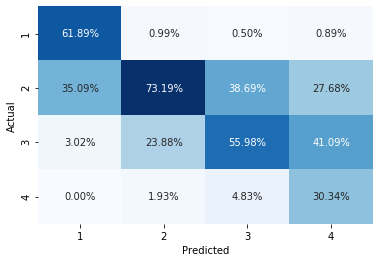

In [125]:
from sklearn.metrics import accuracy_score, confusion_matrix
print("accuracy:", accuracy_score(t, p))

p = []
t = []
for i in y_pred:
    p.append(np.argmax(i)+1)

for i in y_test:
    t.append(np.argmax(i)+1)    

cm=confusion_matrix(t,p)
cm = pd.DataFrame(cm, index = [i for i in "1234"],
                  columns = [i for i in "1234"])
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues', cbar=False)
plt.show()

# Feature selection with Chi sqaure and train test model

In [126]:
# Split into train and test set

data = feather.read_dataframe("{}_v2.feather".format(FILENAME))
data['Severity'] = data['Severity'].astype(int)

# One hot encode labels
n = len(data)
labels = data['Severity']
y = np.zeros((n, 4))
for i in range(n):
    y[i, labels[i]-1] = 1
    
# Get the attributes
X = data.drop('Severity', axis=1)

scaler=MinMaxScaler(feature_range=(0,1))
scaled_features = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.25, random_state=30034)

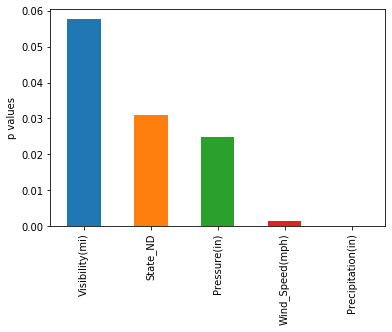

In [132]:
from sklearn.feature_selection import chi2

chi_scores = chi2(scaled_features,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values[:5].plot.bar()
plt.ylabel("p values")
plt.show()

In [142]:
chi = SelectKBest(chi2,k=40)

X_train_chi = chi.fit_transform(X_train,y_train)
X_test_chi = chi.transform(X_test)

In [143]:
EPOCHS = 10
BATCH_SIZE = 128

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(30, activation=tf.nn.swish,input_shape=(X_train_chi.shape[1],))) # Swish indeed performs better than sigmoid
model.add(tf.keras.layers.Dense(4, activation=tf.nn.softmax))

# Compile and print out summary of model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
             metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 124       
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________


In [144]:
# Train the model
model.fit(X_train_chi, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
2163762/2163762 [==============================] - 42s 19us/sample - loss: 0.6637 - acc: 0.6985
Epoch 2/10
2163762/2163762 [==============================] - 43s 20us/sample - loss: 0.6516 - acc: 0.7006
Epoch 3/10
 668544/2163762 [========>.....................] - ETA: 31s - loss: 0.6486 - acc: 0.7008

KeyboardInterrupt: 